In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/oil-spill.csv

--2020-09-12 04:24:34--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/oil-spill.csv
Resolving raw.githubusercontent.com... 151.101.52.133
Connecting to raw.githubusercontent.com|151.101.52.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 230924 (226K) [text/plain]
Saving to: 'oil-spill.csv.1'

oil-spill.csv.1     100%[===================>] 225.51K  --.-KB/s    in 0.05s   

2020-09-12 04:24:35 (4.09 MB/s) - 'oil-spill.csv.1' saved [230924/230924]



In [5]:
# load data
filename = 'oil-spill.csv'
df = pd.read_csv(filename, header=None)
print(df.shape)
# print(df.describe())
target = df.values[:,-1]
counter = Counter(target)
for k, v in counter.items():
    per = v / len(target) * 100
    print(f'Class = {k}, Count = {v}, Percentage = {round(per, 3)}%')

(937, 50)
Class = 1.0, Count = 41, Percentage = 4.376%
Class = 0.0, Count = 896, Percentage = 95.624%


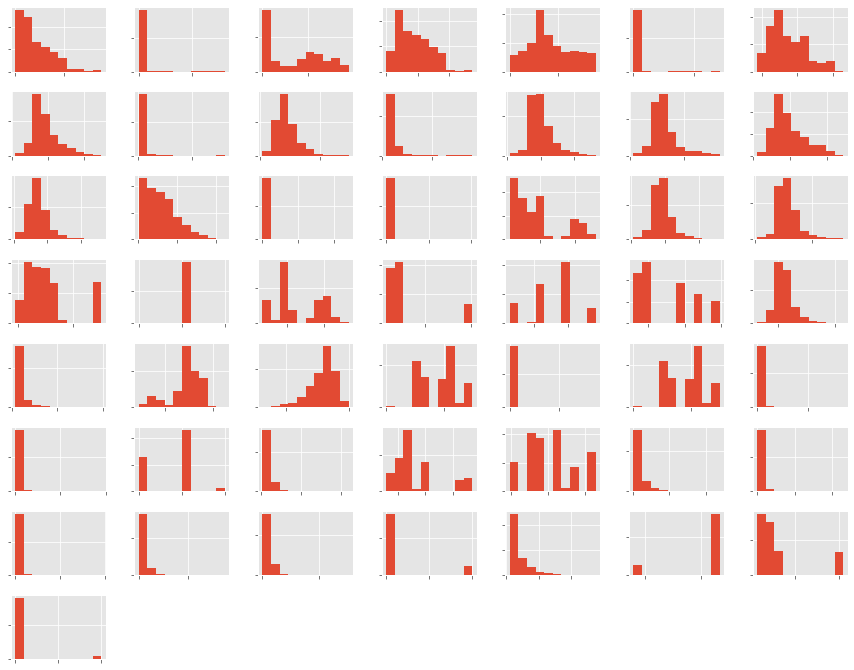

In [6]:
# visualization

ax = df.hist(figsize=(15, 12))
for axis in ax.flatten():
    axis.set_title('')
    axis.set_xticklabels([])
    axis.set_yticklabels([])
plt.show()

# Model Test and Baseline Result

The metrics used in this project is G-Mean, geometric mean. G-Mean has the distinctive property of being independent of the distribution of examples between calsses, and is thus robust in circumstances where this distribution might change with time or be different in the trainng and testing data. 

G-Mean = (Sensitivity * specificity) ^^ 0.5


sensitivity = recall = true positive / (true positive + false negative) measure of the accuracy of positive class

specificity = true negative / (true negative + false positive) measure of the accuracy of negative class

In [7]:
from collections import Counter
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier

In [8]:
## drop variable 1 that defines image ID, and column 22 which has one single number

df.drop([0, 22], axis=1, inplace=True)

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
data = df.values
X, y = data[:, :-1], data[:, -1]
y = LabelEncoder().fit_transform(y)

In [17]:
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    metric = make_scorer(geometric_mean_score)
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

In [18]:
model = DummyClassifier(strategy = 'uniform')

In [25]:
scores = evaluate_model(X,y, model)
print(f'Mean G-Mean is {round(mean(scores),3)}, Std G-Mean is {round(std(scores),3)}')

Mean G-Mean is 0.495, Std G-Mean is 0.203


The baseline model achieves a G-mean of about 0.47, close to the theoritical maximum of 0.5. This score provides a lower limit on model skill. Any model that achieves an average G-mean above about 0.47 or really above 0.5 has skill. Otherwise, no skill. t a good G-mean reported in the paper was about 0.811.

 ## Selecte and evaluate models
 
 Probabilistic models are selected and evaluated on the dataset. Probabilistic models are models that are fit on the data under a probabilistic framework and often peform well in general for imbalanced classification datasets. 
 
 Logistic Regression (LR)
 
 Linear Discriminant Analysis (LDA)
 
 Gaussian Naive Bayes (NB)
 
 Both LR and LDA are sensitive to scale of the inputs data. So that it is better to normalize or standardize the variables in pre-processing step. 


In [40]:
from numpy import mean
from numpy import std
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from imblearn.metrics import geometric_mean_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

In [41]:
def get_models():
    models, names = list(), list()
    
    steps = [('t', StandardScaler()), ('m', LogisticRegression(solver='liblinear'))]
    
    models.append(Pipeline(steps=steps))
    
    names.append('LR')
    
    steps = [('t', StandardScaler()), ('m', LinearDiscriminantAnalysis())]
    models.append(Pipeline(steps=steps))
    names.append('LDA')
    
    models.append(GaussianNB())
    names.append('NB')
    return models, names

LR, 0.672, 0.203
LDA, 0.755, 0.147
NB, 0.707, 0.202


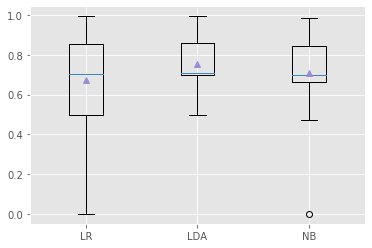

In [42]:
models, names = get_models()

results = list()
for i in range(len(models)):
    scores = evaluate_model(X, y, models[i])
    results.append(scores)
    print(f'{names[i]}, {round(mean(scores),3)}, {round(std(scores),3)}')
    
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [45]:
def get_models():
    models, names = list(), list()
    
    # LR  Balanced
    models.append(LogisticRegression(solver='liblinear', class_weight='balanced'))
    names.append('Balanced')
    
    # LR Normalization and Balanced
    steps = [('t', MinMaxScaler()), ('m', LogisticRegression(solver='liblinear',
                                                             class_weight='balanced'))]
    models.append(Pipeline(steps=steps))
    names.append('Balanced-Norm')
    
    # LR Balanced + Standardization
    steps =[('t', StandardScaler()), ('m', LogisticRegression(solver='liblinear', class_weight='balanced'))]
    models.append(Pipeline(steps=steps))
    names.append('Balanced-STD')
    
    # LR Balanced + Power
    steps = [('t1', MinMaxScaler()), 
             ('t2', PowerTransformer()), 
             ('m', LogisticRegression(solver='liblinear', class_weight='balanced'))]
    models.append(Pipeline(steps=steps))
    names.append('Balanced-Power')
    
    return models, names

Balanced, 0.835, 0.113
Balanced-Norm, 0.836, 0.088
Balanced-STD, 0.834, 0.129
Balanced-Power, 0.862, 0.124


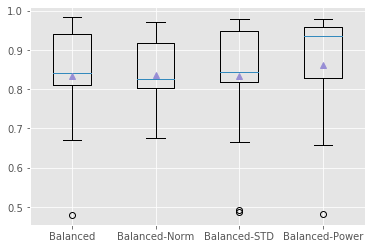

In [46]:
models, names = get_models()

results = list()
for i in range(len(models)):
    scores = evaluate_model(X, y, models[i])
    results.append(scores)
    print(f'{names[i]}, {round(mean(scores),3)}, {round(std(scores),3)}')

plt.boxplot(results, labels=names, showmeans=True)
plt.show()
    

The results suggested that balanced LR model with powertransform is the best performance. 